# Homework 2 - LLM ZOOMCAMP - Rui Pinto

## Q1. Embedding the query
Embed the query: 'I just discovered the course. Can I join now?'. Use the 'jinaai/jina-embeddings-v2-small-en' model.

You should get a numpy array of size 512.

What's the minimal value in this array?

- -0.51
- -0.11 ✅
- 0
- 0.51

In [3]:
# # running and setting up Qdrant in Docker
# !docker pull qdrant/qdrant

# !docker run -d -p 6333:6333 -p 6334:6334 \
#    -v "$(pwd)/qdrant_storage:/qdrant/storage:z" \
#    qdrant/qdrant
   
# # verify docker is running
# !docker ps

In [4]:
# get the documents
import requests

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

In [5]:
# Install the Qdrant client with fastembed support
import json
from fastembed import TextEmbedding
from qdrant_client import QdrantClient, models

# Connect to Qdrant
client = QdrantClient("http://localhost:6333")

# size of the embedding vectors
EMBEDDING_DIMENSIONALITY = 512

### Create a Collection

In [7]:
model_handle = "jinaai/jina-embeddings-v2-small-en"

# Define the collection name
collection_name = "homework02-vector-search"

# delets the collection if it exists
client.delete_collection(collection_name)

# Create the collection with specified vector parameters
client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,  # Dimensionality of the vectors
        distance=models.Distance.COSINE  # Distance metric for similarity search
    )
)

True

### Create, Embed & Insert Points into the Collection

In [8]:
points = []
id = 0

for course in documents_raw:
    for doc in course['documents']:

        point = models.PointStruct(
            id=id,
            vector=models.Document(text=doc['text'], model=model_handle), #embed text locally with "jinaai/jina-embeddings-v2-small-en" from FastEmbed
            payload={
                "text": doc['text'],
                "section": doc['section'],
                "course": course['course']
            } #save all needed metadata fields
        )
        points.append(point)

        id += 1
        
client.upsert(
    collection_name=collection_name,
    points=points
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

### Visualize the collection

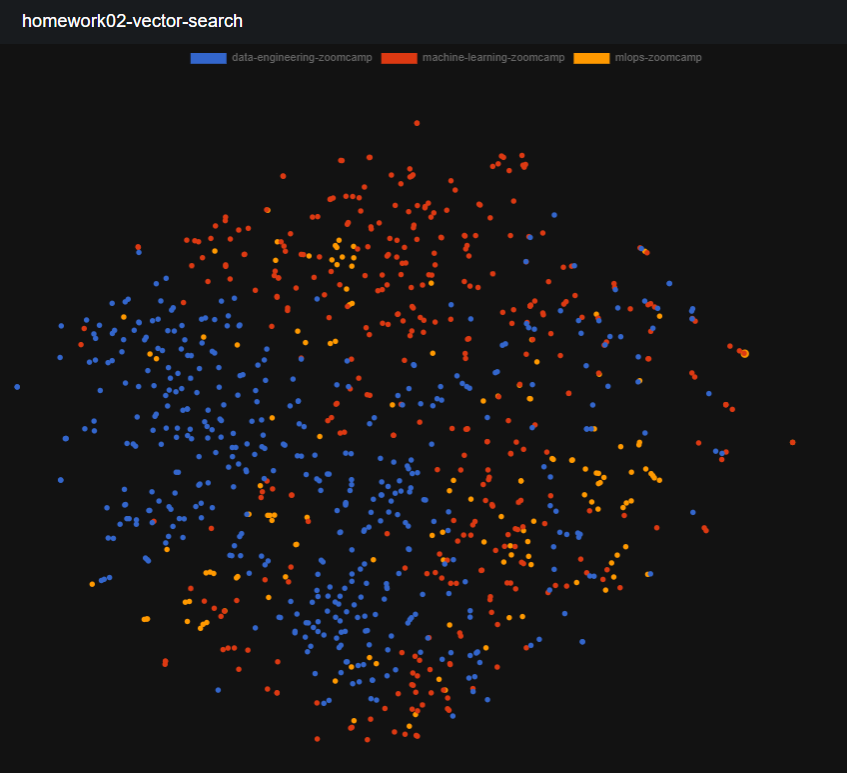

In [9]:
# show image in imagesfolder
from IPython.display import Image, display
display(Image(filename='images/qdrant_collection.png'))

### Search for a document

In [10]:
def search(query, limit=1):

    results = client.query_points(
        collection_name=collection_name,
        query=models.Document( #embed the query text locally with "jinaai/jina-embeddings-v2-small-en"
            text=query,
            model=model_handle 
        ),
        limit=limit, # top closest matches
        with_payload=True #to get metadata in the results
    )

    return results

In [11]:
query_text = "I just discovered the course. Can I join now?"

results = search(query_text, limit=1)

results

QueryResponse(points=[ScoredPoint(id=450, version=0, score=0.8412461, payload={'text': 'The course is available in the self-paced mode too, so you can go through the materials at any time. But if you want to do it as a cohort with other students, the next iterations will happen in September 2023, September 2024 (and potentially other Septembers as well).', 'section': 'General course-related questions', 'course': 'machine-learning-zoomcamp'}, vector=None, shard_key=None, order_value=None)])

In [12]:
import numpy as np

embedding_model = TextEmbedding(model_handle)

# Get the embeddings
embeddings_query = list(embedding_model.embed([query_text]))
query_embedding = embeddings_query[0]

# Check the shape to verify it's 512-dimensional
print(f"Embedding shape: {query_embedding.shape}")

# consine similarity with itself should be 1.0
print(f"Cosine similarity with itself: {np.dot(query_embedding, query_embedding):.4f}")

# Find the minimum value in the array
min_value = np.min(query_embedding)
print(f"Minimum value in the embedding: {min_value:.4f}")

Embedding shape: (512,)
Cosine similarity with itself: 1.0000
Minimum value in the embedding: -0.1173


## Q2. Cosine similarity with another vector

Now let's embed this document:

```bash
doc = 'Can I still join the course after the start date?'
```

What's the cosine similarity between the vector for the query and the vector for the document?

- 0.3
- 0.5
- 0.7
- 0.9 ✅

In [13]:
doc = 'Can I still join the course after the start date?'

# Get the embedding for the document
embeddings_doc = list(embedding_model.embed([doc]))
doc_embedding = embeddings_doc[0]

# Calculate cosine similarity between query and document
cosine_similarity = np.dot(query_embedding, doc_embedding)

print(f"Cosine similarity between query and document: {cosine_similarity:.4f}")

Cosine similarity between query and document: 0.9009


# Q3. Ranking by cosine

For Q3 and Q4 we will use these documents

Compute the embeddings for the text field, and compute the 
cosine between the query vector and all the documents.

What's the document index with the highest similarity? (Indexing starts from 0):

- 0
- 1 ✅
- 2
- 3
- 4

Hint: if you put all the embeddings of the text field in one matrix `V` (a single 2-dimensional numpy array), then
computing the cosine becomes a matrix multiplication:

```python
V.dot(q)
```

If this hint is rather confusing you than helping, feel free
to ignore it.

In [14]:
documents = [{'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
  'section': 'General course-related questions',
  'question': 'Course - Can I still join the course after the start date?',
  'course': 'data-engineering-zoomcamp'},
 {'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.',
  'section': 'General course-related questions',
  'question': 'Course - Can I follow the course after it finishes?',
  'course': 'data-engineering-zoomcamp'},
 {'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp'},
 {'text': 'You can start by installing and setting up all the dependencies and requirements:\nGoogle cloud account\nGoogle Cloud SDK\nPython 3 (installed with Anaconda)\nTerraform\nGit\nLook over the prerequisites and syllabus to see if you are comfortable with these subjects.',
  'section': 'General course-related questions',
  'question': 'Course - What can I do before the course starts?',
  'course': 'data-engineering-zoomcamp'},
 {'text': 'Star the repo! Share it with friends if you find it useful ❣️\nCreate a PR if you see you can improve the text or the structure of the repository.',
  'section': 'General course-related questions',
  'question': 'How can we contribute to the course?',
  'course': 'data-engineering-zoomcamp'}]

In [23]:
# We already have our query embedding from previous cells
query_text = "I just discovered the course. Can I join now?"

# Extract just the text fields from the documents
texts = [doc['text'] for doc in documents]

# Generate embeddings for all documents
doc_embeddings = list(embedding_model.embed(texts))

# Convert to numpy array for easier manipulation
doc_embeddings_array = np.array(doc_embeddings)

# Calculate cosine similarities between query and all documents
# Using matrix multiplication as suggested in the hint
similarities = np.dot(doc_embeddings_array, query_embedding)

# Display similarities with their indices
for i, sim in enumerate(similarities):
    print(f"Document {i}: Similarity = {sim:.4f}")

# Find the document with the highest similarity
most_similar_idx = np.argmax(similarities)
print(f"\nDocument with highest similarity: {most_similar_idx}")

Document 0: Similarity = 0.7630
Document 1: Similarity = 0.8182
Document 2: Similarity = 0.8085
Document 3: Similarity = 0.7133
Document 4: Similarity = 0.7304

Document with highest similarity: 1


## Q4. Ranking by cosine, version two

Now let's calculate a new field, which is a concatenation of
`question` and `text`:

```python
full_text = doc['question'] + ' ' + doc['text']
``` 

Embed this field and compute the cosine between it and the
query vector. What's the highest scoring document?

- 0 ✅
- 1
- 2
- 3
- 4

Is it different from Q3? If yes, why?

In [25]:
full_texts = [doc['question'] + ' ' + doc['text'] for doc in documents]

# Generate embeddings for all documents
doc_embeddings = list(embedding_model.embed(full_texts))

# Convert to numpy array for easier manipulation
doc_embeddings_array = np.array(doc_embeddings)

# Calculate cosine similarities between query and all documents
# Using matrix multiplication as suggested in the hint
similarities = np.dot(doc_embeddings_array, query_embedding)

# Display similarities with their indices
for i, sim in enumerate(similarities):
    print(f"Document {i}: Similarity = {sim:.4f}")

# Find the document with the highest similarity
most_similar_idx = np.argmax(similarities)
print(f"\nDocument with highest similarity: {most_similar_idx}")

Document 0: Similarity = 0.8515
Document 1: Similarity = 0.8437
Document 2: Similarity = 0.8408
Document 3: Similarity = 0.7755
Document 4: Similarity = 0.8086

Document with highest similarity: 0


The difference between Q3 and Q4 is that:

- In Q3, we were only embedding and comparing the text field
- In Q4, we're embedding and comparing question + text

By including the question field, we've added crucial information that closely matches the intent of your query. Document 0's question explicitly mentions "joining the course after the start date" which aligns perfectly with your query about joining now.

This demonstrates an important principle in semantic search: the content you choose to include in your embeddings can significantly impact search results. Including more targeted metadata (like question fields) can help the search engine better match user intent.

## Q5. Selecting the embedding model

Now let's select a smaller embedding model.
What's the smallest dimensionality for models in fastembed?

- 128
- 256
- 384 ✅
- 512

One of these models is `BAAI/bge-small-en`. Let's use it.

In [26]:
# Print all supported models and their dimensions
supported_models = TextEmbedding.list_supported_models()
print(f"Number of supported models: {len(supported_models)}")

# Extract and display model info in a readable format
for model_info in supported_models:
    model_name = model_info['model']
    dim = model_info['dim']
    print(f"Model: {model_name}, Dimension: {dim}")

Number of supported models: 30
Model: BAAI/bge-base-en, Dimension: 768
Model: BAAI/bge-base-en-v1.5, Dimension: 768
Model: BAAI/bge-large-en-v1.5, Dimension: 1024
Model: BAAI/bge-small-en, Dimension: 384
Model: BAAI/bge-small-en-v1.5, Dimension: 384
Model: BAAI/bge-small-zh-v1.5, Dimension: 512
Model: mixedbread-ai/mxbai-embed-large-v1, Dimension: 1024
Model: snowflake/snowflake-arctic-embed-xs, Dimension: 384
Model: snowflake/snowflake-arctic-embed-s, Dimension: 384
Model: snowflake/snowflake-arctic-embed-m, Dimension: 768
Model: snowflake/snowflake-arctic-embed-m-long, Dimension: 768
Model: snowflake/snowflake-arctic-embed-l, Dimension: 1024
Model: jinaai/jina-clip-v1, Dimension: 768
Model: Qdrant/clip-ViT-B-32-text, Dimension: 512
Model: sentence-transformers/all-MiniLM-L6-v2, Dimension: 384
Model: jinaai/jina-embeddings-v2-base-en, Dimension: 768
Model: jinaai/jina-embeddings-v2-small-en, Dimension: 512
Model: jinaai/jina-embeddings-v2-base-de, Dimension: 768
Model: jinaai/jina-emb

In [27]:
# print the smallest model
smallest_model = min(supported_models, key=lambda x: x['dim'])
print(f"\nSmallest model: {smallest_model['model']} with dimension {smallest_model['dim']}")


Smallest model: BAAI/bge-small-en with dimension 384


## Q6. Indexing with qdrant (2 points)

For the last question, we will use more documents.

We will select only FAQ records from our ml zoomcamp:

```python
import requests 

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()


documents = []

for course in documents_raw:
    course_name = course['course']
    if course_name != 'machine-learning-zoomcamp':
        continue

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)
```

Add them to qdrant using the model form Q5.

When adding the data, use both question and answer fields:

```python
text = doc['question'] + ' ' + doc['text']
```

After the data is inserted, use the question from Q1 for querying the collection.

What's the highest score in the results?
(The score for the first returned record):

- 0.97
- 0.87 ✅
- 0.77
- 0.67

In [40]:
# First, get the documents from the machine-learning-zoomcamp course
import requests

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

# Filter only ML zoomcamp documents
ml_documents = []
for course in documents_raw:
    course_name = course['course']
    if course_name != 'machine-learning-zoomcamp':
        continue
        
    for doc in course['documents']:
        doc['course'] = course_name
        ml_documents.append(doc)

print(f"Number of ML zoomcamp documents: {len(ml_documents)}")

# Use the smaller model from Q5 - BAAI/bge-small-en
small_model_handle = "BAAI/bge-small-en"
small_embedding_model = TextEmbedding(small_model_handle)

# Get the dimension for this model
small_embedding_dim = 384  # Based on your results from Q5

# Create a new collection for Q6
q6_collection_name = "homework02-q6"

# Delete if exists and recreate
client.delete_collection(q6_collection_name)
client.create_collection(
    collection_name=q6_collection_name,
    vectors_config=models.VectorParams(
        size=small_embedding_dim,
        distance=models.Distance.COSINE
    )
)

# Create and insert points with question + text
points = []
id = 0

for doc in ml_documents:
    # Combine question and text as required
    full_text = doc['question'] + ' ' + doc['text']
    
    point = models.PointStruct(
        id=id,
        vector=models.Document(text=full_text, model=small_model_handle),
        payload={
            "text": doc['text'],
            "question": doc['question'],
            "full_text": full_text,
            "course": doc['course']
        }
    )
    points.append(point)
    id += 1

# Insert into Qdrant
client.upsert(
    collection_name=q6_collection_name,
    points=points
)

# Use the query from Q1 to search
query_text = "I just discovered the course. Can I join now?"

# Search the collection
results = client.query_points(
    collection_name=q6_collection_name,
    query=models.Document(
        text=query_text,
        model=small_model_handle
    ),
    limit=1,  # Get top 1 results to see all scores
    with_payload=True
)

# Display the score for the top result
print(f"Highest score: {results.points[0].score:.4f}")

# You can also get more information about the result
print(f"Question: {results.points[0].payload['question']}")
print(f"Text: {results.points[0].payload['text'][:100]}...")

Number of ML zoomcamp documents: 375
Highest score: 0.8703
Question: The course has already started. Can I still join it?
Text: Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the ...
